In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import hockey.hockey_env as h_env

from rl_hockey.DDDQN import DDDQN
from rl_hockey.common import utils

In [41]:
env = h_env.HockeyEnv(mode=h_env.Mode.TRAIN_SHOOTING)

o_space = env.observation_space
discrete_action_dim = 7 if not env.keep_mode else 8

In [42]:
# Training hyperparameters
max_episodes = 500
max_episode_steps = 500
updates_per_step = 1
warmup_steps = 10000

In [43]:
agent = DDDQN(
    o_space.shape[0],
    action_dim=discrete_action_dim,
    hidden_dim=[256, 256, 256],
    **{
        'target_update_freq': 60,
        'batch_size': 32,
        'learning_rate': 0.0001,
        "eps": 1,
        "eps_min": 0.2,
        "eps_decay": 0.999,
        'use_huber_loss': True,  # Huber loss more stable for large reward scales
    }
)


In [44]:
losses = []
rewards = []
steps = 0
gradient_steps = 0

In [45]:
run_name = 'hockey-shooting-ddqn'

In [46]:
# Use constant reward shaping weights: no schedule, always the same throughout training

REWARD_WEIGHTS = {
    'closeness': 5.0,
    'touch': 10.0,
    'direction': 2.0,
}

pbar = tqdm(range(max_episodes), desc=run_name)
for i in pbar:    
    total_reward = 0
    total_shaped_reward = 0
    state, _ = env.reset()

    agent.on_episode_start(i)

    reward_weights = REWARD_WEIGHTS  # Always constant

    for t in range(max_episode_steps):
        done = False
        discrete_action = agent.act(state.astype(np.float32))
        
        action_p1 = env.discrete_to_continous_action(discrete_action)
        action_p2 = np.zeros(len(action_p1))

        action = np.hstack([action_p1, action_p2])
        
        # Get info dictionary for proxy rewards
        (next_state, reward, done, trunc, info) = env.step(action)
        
        # Shape reward: start with base reward, add closeness/touch/direction always with constant weights
        shaped_reward = reward  # Base sparse reward (+10/-10 at end)
        shaped_reward += info.get('reward_closeness_to_puck', 0.0) * reward_weights['closeness']
        shaped_reward += info.get('reward_touch_puck', 0.0) * reward_weights['touch']
        shaped_reward += info.get('reward_puck_direction', 0.0) * reward_weights['direction']
        
        # Scale reward to normalize large shaped rewards for stable Q-learning
        scaled_reward = shaped_reward
        
        # Store original transition
        discrete_action_array = np.array([discrete_action], dtype=np.float32)
        agent.store_transition((state, discrete_action_array, scaled_reward, next_state, done))
        
        # Store mirrored transition with CORRECTED mirrored action
        mirrored_action = utils.mirror_discrete_action(discrete_action)
        mirrored_action_array = np.array([mirrored_action], dtype=np.float32)
        agent.store_transition((utils.mirror_state(state), mirrored_action_array, scaled_reward, utils.mirror_state(next_state), done))
        
        state = next_state

        steps += 1
        total_reward += reward  # Track original sparse reward for monitoring
        total_shaped_reward += shaped_reward  # Track shaped reward

        if steps >= warmup_steps:
            stats = agent.train(updates_per_step)

            gradient_steps += updates_per_step
            losses.extend(stats['loss'])

        if done or trunc:
            break

    agent.on_episode_end(i)

    rewards.append(total_reward)  # Store original reward for plotting
    
    pbar.set_postfix({
        'reward': total_reward,
        'shaped': f'{total_shaped_reward:.1f}',
        'eps': agent.config['eps'],
        'closeness_w': f"{reward_weights['closeness']:.2f}",
        'touch_w': f"{reward_weights['touch']:.2f}",
        'dir_w': f"{reward_weights['direction']:.2f}"
    })



hockey-shooting-ddqn:   0%|          | 0/500 [00:00<?, ?it/s, reward=-33.6, shaped=-201.4, eps=0.999, closeness_w=5.00, touch_w=10.00, dir_w=2.00]

hockey-shooting-ddqn: 100%|██████████| 500/500 [03:11<00:00,  2.61it/s, reward=-22.6, shaped=-75.6, eps=0.606, closeness_w=5.00, touch_w=10.00, dir_w=2.00] 


In [47]:
from datetime import datetime
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
agent.save(f'../../../models/dddqn/{run_name}_{gradient_steps//1000}k_{timestamp}.pt')

In [48]:
def moving_average(data, window_size):
    moving_averages = []
    for i in range(len(data)):
        window_start = max(0, i - window_size + 1)
        window = data[window_start:i + 1]
        moving_averages.append(sum(window) / len(window))
    
    return moving_averages

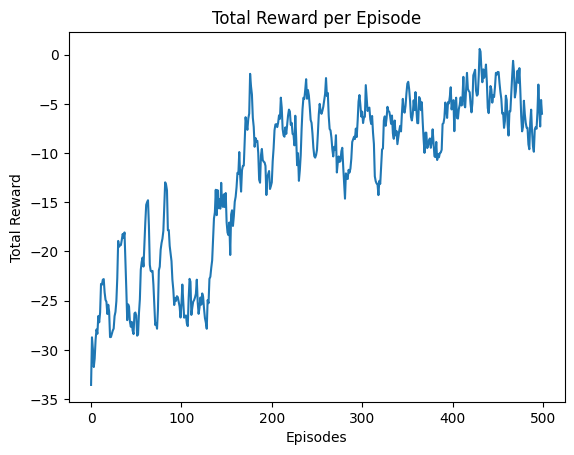

In [49]:
plt.plot(moving_average(rewards, 10))
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

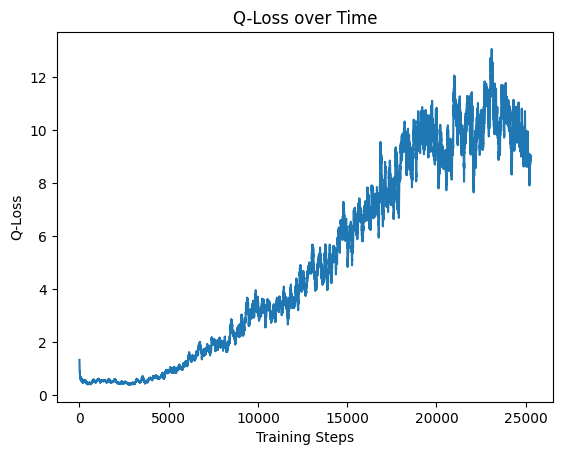

In [50]:
plt.plot(moving_average(losses, 100))
plt.xlabel('Training Steps')
plt.ylabel('Q-Loss')
plt.title('Q-Loss over Time')
plt.show()

In [51]:
env = h_env.HockeyEnv(mode=h_env.Mode.TRAIN_SHOOTING)

In [52]:
total_reward = 0
state, _ = env.reset()
for t in range(max_episode_steps):
    env.render(mode="human")

    done = False
    discrete_action = agent.act(state.astype(np.float32), deterministic=True)
    
    action_p1 = env.discrete_to_continous_action(discrete_action)
    action_p2 = np.zeros(len(action_p1))
    action = np.hstack([action_p1, action_p2])
    
    (next_state, reward, done, trunc, _) = env.step(action)
    state = next_state

    total_reward += reward

    if done or trunc:
        break

print(f'total_reward: {total_reward}')

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM default


total_reward: 7.7358953906402785


In [53]:
env.close()